In [ ]:
from os import PathLike
from os.path import join as joinpath
from time import time
from typing import Union, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    LSTM,
    Dense,
    Reshape,
    concatenate
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

BATCH_SIZE = 64
LOOKUP_WINDOW_SIZE = 100
EPOCHS = 200

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import datetime
# Load the TensorBoard notebook extension
%load_ext tensorboard
tb_log  = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_path = 'Train_Dst_NoAuction_ZScore_CF_9.txt'
test_path  = 'Test_Dst_NoAuction_ZScore_CF_9.txt'
model_path = f'model_{int(time())}.h5'

try:
    from google.colab import drive
    drive.mount('/content/drive')
    LOB_TRADING_DIR = '/content/drive/MyDrive/Colab Notebooks/LOB Trading/'
    MODEL_TRADING_DIR = '/content/drive/MyDrive/Colab Notebooks/'
    train_path = joinpath(LOB_TRADING_DIR, train_path)
    test_path  = joinpath(LOB_TRADING_DIR, test_path)
    model_path = joinpath(MODEL_TRADING_DIR, model_path)
    tb_path = joinpath(MODEL_TRADING_DIR, tb_log)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_path, histogram_freq=1)
except ModuleNotFoundError:
    pass

Mounted at /content/drive


In [ ]:
def read_data(path: Union[str, PathLike]) -> pd.DataFrame:
    with open(path, 'r') as file:
        data = [
            tuple(map(float, line.split()))
            for line in tqdm(file)
        ]
    data = pd.DataFrame(data)
    #   
    data = data.loc[list(data.index[:40]) + list(data.index[-5:])]
    data = data.T

    # Same notation as in http://dx.doi.org/10.1002/for.2543
    target_names = [f'l{i:02}' for i in (1, 2, 3, 5, 10)]

    colnames = [
        f'{feature}{i}'
        for i in range(10)
        for feature in ('Pa', 'Va', 'Pb', 'Vb')
    ]
    colnames += target_names

    data.columns = colnames
    for tg in target_names:
        data[tg] = data[tg].astype(int)
        data[tg] -= 1  # Needed for tensorflow.keras.utils.to_categorical
    return data


def get_ts_generator(data: pd.DataFrame,
                     target_name: str,
                     num_features: int = 40) -> TimeseriesGenerator:

    X = data.iloc[:, :num_features].values
    X = X[..., None]  # needed for CNN input
    y = to_categorical(data[target_name].shift(fill_value=0))
    # Shift forward by 1, since TimeSeriesGenerator maps every X[i] with y[i+1], but not with y[i]
    return TimeseriesGenerator(X, y, LOOKUP_WINDOW_SIZE, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
train_data = read_data(train_path)
test_data  = read_data(test_path)
train_data

149it [00:18,  8.10it/s]
149it [00:02, 56.40it/s]


,Pa0,Va0,Pb0,Vb0,Pa1,Va1,Pb1,Vb1,Pa2,Va2,Pb2,Vb2,Pa3,Va3,Pb3,Vb3,Pa4,Va4,Pb4,Vb4,Pa5,Va5,Pb5,Vb5,Pa6,Va6,Pb6,Vb6,Pa7,Va7,Pb7,Vb7,Pa8,Va8,Pb8,Vb8,Pa9,Va9,Pb9,Vb9,l01,l02,l03,l05,l10
0,0.318116,-0.564619,0.313539,-0.551889,0.319726,-0.731228,0.312891,-0.425448,0.319404,-0.844157,0.312254,-0.571766,0.319138,-0.769659,0.311546,-0.619174,0.318881,-0.956744,0.311819,-0.885627,0.319478,-0.492876,0.309257,-0.807128,0.319920,-0.703866,0.308812,-0.742000,0.319202,-0.357451,0.308565,-0.624978,0.320242,-0.483313,0.307526,-0.533218,0.322061,-0.427763,0.300703,-0.480828,1,1,1,1,1
1,0.318116,-0.662079,0.313539,-0.551889,0.320706,-0.751891,0.312891,-0.425448,0.320383,-0.854876,0.312254,-0.571766,0.320117,-0.764619,0.312528,-0.802672,0.322798,-0.957195,0.312802,-0.749327,0.322415,-0.516778,0.313188,-0.781772,0.323834,-0.705590,0.310778,-0.761182,0.326050,-0.519047,0.310532,-0.621590,0.328063,-0.478852,0.310478,-0.530020,0.334763,-0.462173,0.309565,-0.481944,1,1,1,1,1
2,0.317136,-0.723163,0.313539,-0.551889,0.316787,-0.731228,0.312891,-0.425448,0.317445,-0.762942,0.312254,-0.571766,0.318159,-0.951519,0.312528,-0.802672,0.317902,-0.962596,0.312802,-0.749327,0.317521,-0.632462,0.313188,-0.781772,0.319920,-0.703866,0.310778,-0.761182,0.319202,-0.357451,0.310532,-0.621590,0.320242,-0.483313,0.310478,-0.530020,0.322061,-0.427763,0.309565,-0.481944,2,2,1,1,1
3,0.317136,-0.585895,0.313539,-0.551889,0.318747,-0.307628,0.312891,-0.425448,0.319404,-0.561348,0.312254,-0.571766,0.319138,-0.769659,0.311546,-0.619174,0.318881,-0.956744,0.311819,-0.885627,0.321436,-0.821286,0.309257,-0.807128,0.323834,-0.705590,0.308812,-0.742000,0.326050,-0.519047,0.308565,-0.624978,0.328063,-0.478852,0.307526,-0.533218,0.334763,-0.462173,0.300703,-0.480828,1,1,2,1,1
4,0.317136,-0.585895,0.313539,-0.551889,0.318747,-0.307628,0.312891,-0.425448,0.319404,-0.561348,0.312254,-0.571766,0.319138,-0.922437,0.311546,-0.619174,0.318881,-0.779397,0.311819,-0.885627,0.321436,-0.821286,0.309257,-0.807128,0.323834,-0.705590,0.308812,-0.742000,0.326050,-0.519047,0.308565,-0.624978,0.328063,-0.478852,0.307526,-0.533218,0.334763,-0.462173,0.300703,-0.480828,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362395,1.328480,-0.608544,1.329517,-0.550603,1.327892,-0.795514,1.330085,-0.719126,1.328302,-0.870542,1.330707,-0.795843,1.330779,-0.890641,1.331192,-0.490725,1.330349,-0.641660,1.331664,-0.909209,1.329733,-0.239996,1.332312,-0.656713,1.328899,-0.412445,1.333185,-0.694266,1.327774,-0.522781,1.333393,-0.592603,1.326325,0.105092,1.334906,-0.478272,1.324595,-0.469732,1.335614,-0.369642,0,0,0,0,0
362396,1.328480,-0.608544,1.329517,-0.550603,1.327892,-0.795514,1.330085,-0.611748,1.328302,-0.870542,1.330707,-0.795843,1.330779,-0.890641,1.331192,-0.490725,1.330349,-0.641660,1.331664,-0.729342,1.329733,-0.239996,1.331329,-0.742665,1.328899,-0.712057,1.331219,-0.707649,1.327774,-0.522781,1.332409,-0.557970,1.326325,0.250666,1.332938,-0.386987,1.324595,-0.469732,1.333645,-0.278103,1,1,0,0,0
362397,1.328480,-0.608544,1.329517,-0.550603,1.327892,-0.795514,1.330085,-0.611748,1.328302,-0.870542,1.330707,-0.795843,1.330779,-0.890641,1.331192,-0.490725,1.330349,-0.979701,1.331664,-0.909209,1.329733,-0.239996,1.332312,-0.656713,1.328899,-0.712057,1.333185,-0.493515,1.327774,-0.522781,1.333393,-0.592603,1.326325,0.250666,1.334906,-0.478272,1.324595,-0.469732,1.335614,-0.369642,1,1,1,0,0
362398,1.328480,-0.668256,1.329517,-0.354503,1.327892,-0.795514,1.330085,-0.611748,1.328302,-0.870542,1.330707,-0.795843,1.330779,-0.890641,1.331192,-0.606696,1.330349,-0.979701,1.331664,-0.729342,1.329733,-0.239996,1.331329,-0.742665,1.328899,-0.712057,1.331219,-0.707649,1.327774,-0.522781,1.332409,-0.557970,1.326325,0.250666,1.332938,-0.188135,1.324595,-0.469732,1.333645,-0.433049,1,1,1,0,0


In [ ]:
target_name = 'l03'

target_class_proportion  = test_data[target_name].value_counts()
target_class_proportion /= target_class_proportion.sum()
target_class_proportion

1    0.504994
0    0.258634
2    0.236372
Name: l03, dtype: float64

In [ ]:
train_gen = get_ts_generator(train_data, target_name=target_name)
test_gen  = get_ts_generator(test_data,  target_name=target_name)

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.epsilon = 1e-6

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=self.epsilon)
        self.layernorm2 = layers.LayerNormalization(epsilon=self.epsilon)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_model(num_features: int = 40, num_lstm_cells: int = 64) -> Model:
    input_lmd = Input(shape=(LOOKUP_WINDOW_SIZE, num_features, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)

    # build the last LSTM layer
    #conv_lstm = LSTM(num_lstm_cells)(conv_reshape)
    transf = TransformerBlock(192,1,32)(conv_reshape)
    x = layers.GlobalAveragePooling1D()(transf)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="relu")(x) 
    x = layers.Dropout(0.1)(x)
    # build the output layer
    out = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_lmd, outputs=out)
    adam  = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', f1_m])

    return model

In [ ]:
model = get_model()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 100, 20, 32)  96          input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_98 (LeakyReLU)      (None, 100, 20, 32)  0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 100, 20, 32)  4128        leaky_re_lu_98[0][0]             
____________________________________________________________________________________________

In [ ]:
#tf.keras.utils.plot_model(model, to_file='trans.png', show_shapes=False, show_layer_names = False)

In [ ]:
model_saver = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    mode='auto',
    verbose=0,
    save_best_only=True,
    save_weights_only=False
)

history = model.fit(
    train_gen,
    epochs=100,
    verbose=1,
    validation_data=test_gen,
    callbacks=[model_saver, tensorboard_callback]
)

Epoch 1/100
5661/5661 [==============================] - 125s 22ms/step - loss: 1.0584 - accuracy: 0.4677 - f1_m: 0.2230 - val_loss: 1.0150 - val_accuracy: 0.5232 - val_f1_m: 0.4636
Epoch 2/100
5661/5661 [==============================] - 122s 21ms/step - loss: 1.0435 - accuracy: 0.4740 - f1_m: 0.2577 - val_loss: 1.0183 - val_accuracy: 0.5201 - val_f1_m: 0.4772
Epoch 3/100
5661/5661 [==============================] - 122s 21ms/step - loss: 1.0336 - accuracy: 0.4746 - f1_m: 0.2687 - val_loss: 1.0145 - val_accuracy: 0.5179 - val_f1_m: 0.4428
Epoch 4/100
5661/5661 [==============================] - 122s 22ms/step - loss: 1.0272 - accuracy: 0.4781 - f1_m: 0.2826 - val_loss: 1.0187 - val_accuracy: 0.5190 - val_f1_m: 0.4467
Epoch 5/100
5661/5661 [==============================] - 122s 21ms/step - loss: 1.0239 - accuracy: 0.4795 - f1_m: 0.2909 - val_loss: 1.0170 - val_accuracy: 0.5225 - val_f1_m: 0.4561
Epoch 6/100
5661/5661 [==============================] - 122s 21ms/step - loss: 1.0219 - a

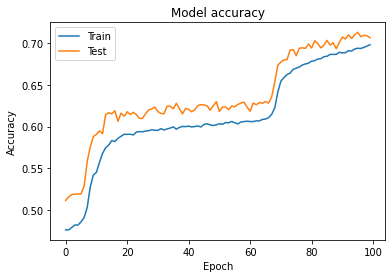

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()